# Setup

In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


plt.style.use('seaborn')

In [2]:
def plot_critical_baseline (run_folder: str):
    file_names = ['ERDOS_REYNI.csv', 'BARABASI_ALBERT.csv']
    
    plt.figure(figsize=(7, 4))
    
    for file_name in file_names:
        run_folder_path = os.path.join(os.path.abspath('../'), 'records', run_folder, file_name)
    
        results_df = pd.read_csv(run_folder_path)
    
        Xy = list(zip(results_df['InfectionRate'].values, results_df['TotalInfected'].values))
        Xy.sort()
    
        plt.scatter([x for x, _ in Xy], [y for _, y in Xy], label=file_name[:-4])
        plt.plot([x for x, _ in Xy], [y for _, y in Xy], alpha=0.25)
        
    plt.title('Infection Rate vs Total Infections')
    plt.xlabel('Infection Rate, β')
    plt.ylabel('Total Infections')
    
    plt.legend()
    plt.show()

In [31]:
def plot_results (run_folder: str, strategy: str):
    run_folder_path = os.path.join(os.path.abspath('../'), 'records', run_folder)
    
    results = {
        'Infected': {
            'Color': 'red',
            'Totals': [],
            'STD': [] 
        },
        'Hospitalised': {
            'Color': 'green',
            'Totals': [],
            'STD': [] 
        },
        'Dead': {
            'Color': 'blue',
            'Totals': [],
            'STD': [] 
        },
    }
    
    for filename in os.listdir(run_folder_path):
        filename_path = os.path.join(run_folder_path, filename)
        match = re.match(r'[A-Z]+_[A-Z]+_[A-Z]+_(\d+\.\d+)_totals.csv', filename)
        
        if match is None:
            continue
        
        rho = float(match.groups()[0])
        
        totals_df = pd.read_csv(filename_path)
        
        for key in results.keys():
            results[key]['Totals'].append((rho, totals_df.iloc[-1][key]))
            results[key]['STD'].append((rho, totals_df.iloc[-1][key + '_STD']))
        
    for key in results.keys():
        results[key]['Totals'].sort()
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6*3, 4))
    
    # * Subplot 1 = Final Totals vs Rhos
    for key in results.keys():
        X = [x for x, _ in results[key]['Totals']]
        y = [y for _, y in results[key]['Totals']]
        yerr = [y for _, y in results[key]['STD']]
        
        # axes[0].errorbar(X, y, yerr=yerr, fmt="o", label=key)
        axes[0].scatter(X, y, label=key)
        axes[0].errorbar(X, y, yerr=yerr, alpha=0.25)
    
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(-0.025, 1)
    axes[0].set_title('Rhos vs State Totals')
    axes[0].set_xlabel('Percentage of Population Vaccinateed, ρ')
    axes[0].set_ylabel('Total Percentage of Population')
    axes[0].legend()
    
    # * Subplot 2 = Epidemic Thresholds for different rhos
    critical_folder_path = os.path.join(os.path.abspath('../'), 'records', 'critical_'+run_folder)
    for filename in os.listdir(critical_folder_path):
        filename_path = os.path.join(critical_folder_path, filename)
        match = re.match(r'(?:[A-Z]+\_)+\d+\_(\d+\.\d+)', filename)
        
        if match is None:
            continue
        
        rho = float(match.groups(0)[0])
        results_df = pd.read_csv(filename_path)
        
        Xy = list(zip(results_df['InfectionRate'].values, results_df['TotalInfected'].values))
        Xy.sort()
        
        axes[1].scatter([x for x, _ in Xy], [y for _, y in Xy], label=f'rho={rho:.3f}')
        axes[1].plot([x for x, _ in Xy], [y for _, y in Xy], alpha=0.25)
        
        axes[1].legend()
        
    axes[1].set_title('Infection Rate vs Total Infections')
    axes[1].set_xlabel('Infection Rate, β')
    axes[1].set_ylabel('Total Infections')
    
    # * Subplot 3 = 'Flatness' measure
    peak_results = []
    spread_results = []
    
    for filename in os.listdir(run_folder_path):
        filename_path = os.path.join(run_folder_path, filename)
        match = re.match(r'[A-Z]+_[A-Z]+_[A-Z]+_(\d+\.\d+)_states.csv', filename)
        
        if match is None:
            continue
        
        rho = float(match.groups()[0])
        
        states_df = pd.read_csv(filename_path)
        
        spread_results.append((rho, np.std(states_df['Hospitalised'].values))) 
        peak_results.append((rho, max(states_df['Hospitalised'].values)))
         
    spread_results.sort()
    peak_results.sort()
    
    axes[2].plot([x for x, _ in spread_results], [y for _, y in spread_results], label='Spread of curve')
    axes[2].plot([x for x, _ in peak_results], [y for _, y in peak_results], label='Peak of curve')
    axes[2].set_title("Rhos vs 'Flatness' of Hospitalised Curve")
    axes[2].set_xlabel('Percentage of Population Vaccinateed, ρ')
    axes[2].set_ylabel("'Flatness' of Hospitalised Curve")
    
    axes[2].legend()
    
    plt.show()

In [4]:
def plot_heatmap(run_folder: str, state: str):
    run_folder_path = os.path.join(os.path.abspath('../'), 'records', run_folder)

    df = pd.DataFrame(columns=['R', 'Rho', 'Value'])
    
    for filename in os.listdir(run_folder_path):
        filename_path = os.path.join(run_folder_path, filename)

        match = re.match(r'r=(\d+\.\d+)_rho=(\d+\.\d+)', filename)
        
        if match is None:
            continue
        
        r = float(match.groups(0)[0])
        rho = float(match.groups(0)[1])
        
        if r + rho > 1:
            continue
        
        totals_df = pd.read_csv(os.path.join(filename_path, 'totals.csv'))
        value = totals_df.iloc[-1][state]
        
        row = {'R': r, 'Rho': rho, 'Value': value}
        
        new_df = pd.DataFrame([row])
        df = pd.concat([df, new_df], axis=0, ignore_index=True)
        
    result = df.pivot(index='R', columns='Rho', values='Value')
    ax = sns.heatmap(result, annot=True, cmap=sns.color_palette("Blues", as_cmap=True))
    ax.invert_yaxis()
    
    plt.title('Total ' + state)

    plt.show()

# Baseline Results

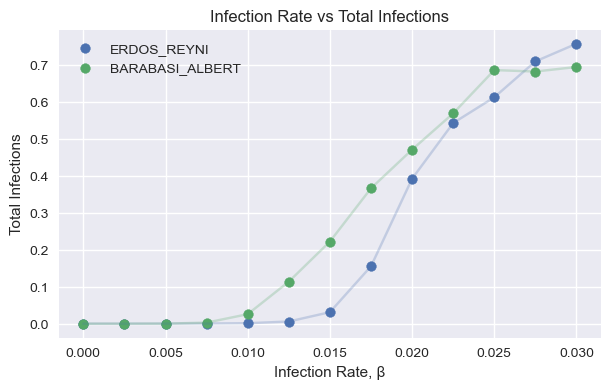

In [5]:
plot_critical_baseline('critical_baseline')

# Section 1 - Random Initial Vaccination

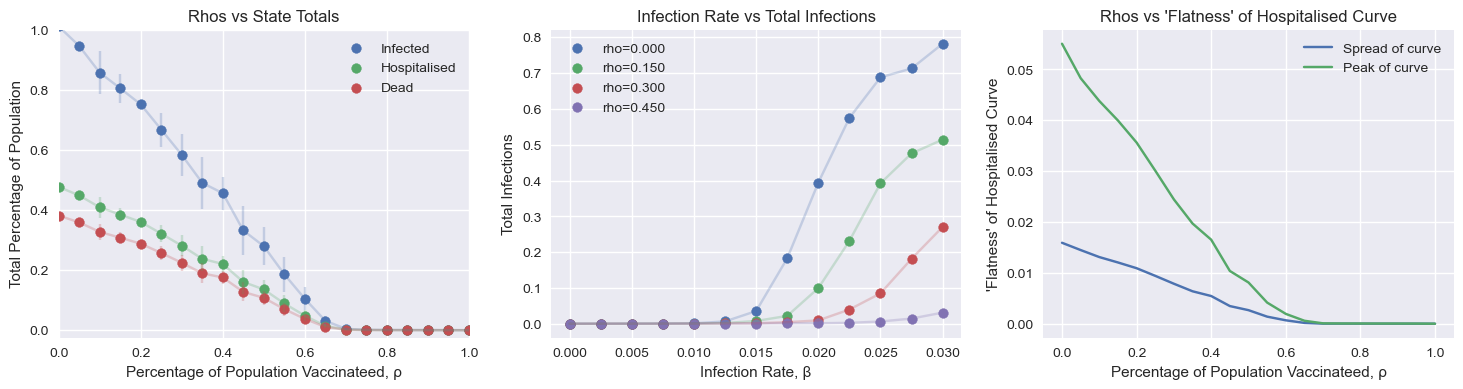

In [32]:
plot_results('section_1a', 'RandomOneOff')

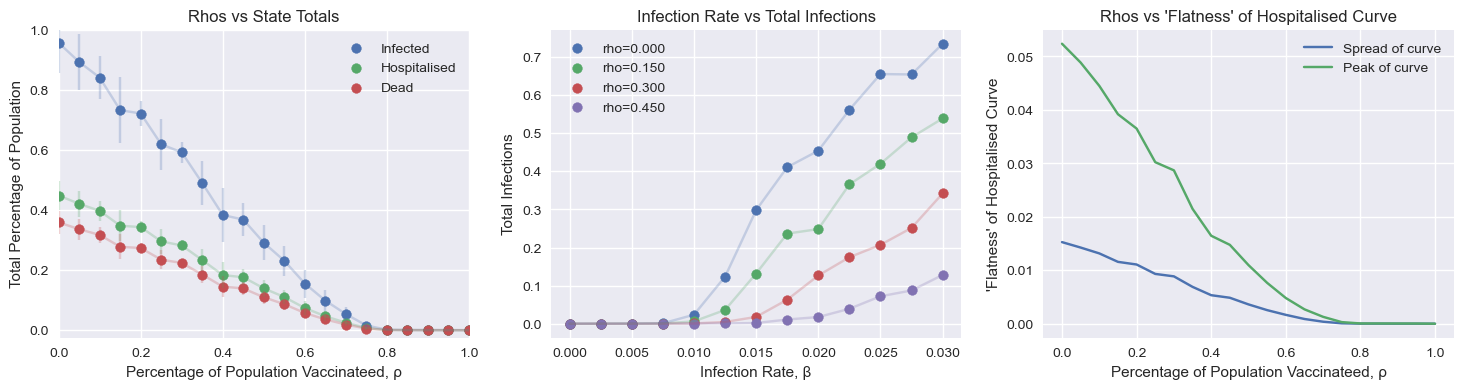

In [33]:
plot_results('section_1b', 'RandomOneOff')

# Section 2 - Highest/Lowest Degree Initial Vaccination

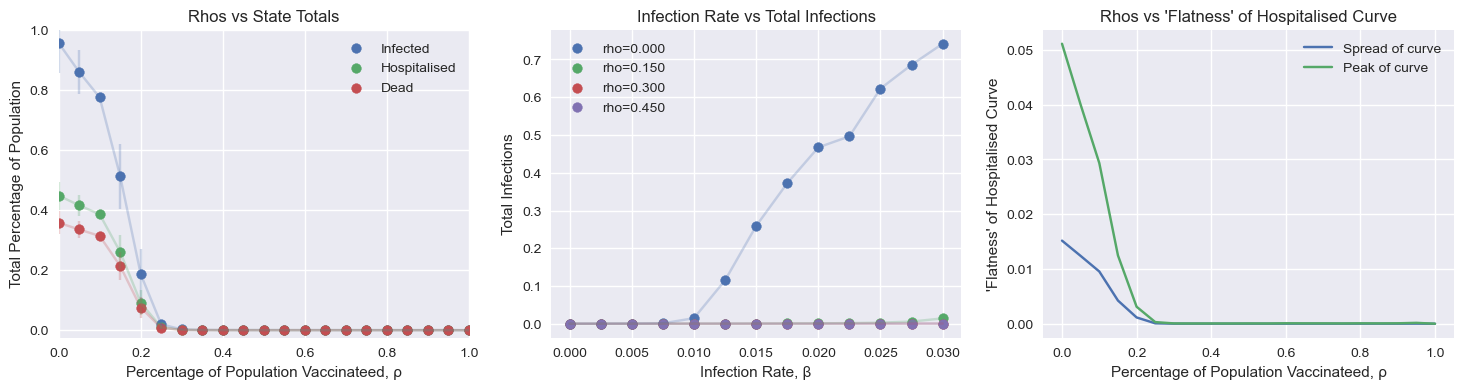

In [34]:
plot_results('section_2a', 'HighestOneOff')

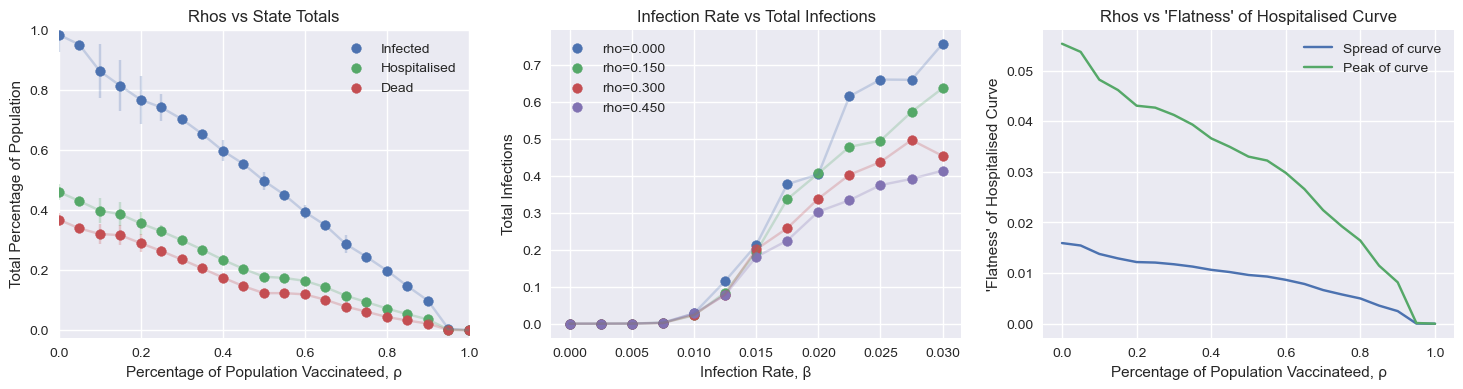

In [35]:
plot_results('section_2b', 'LowestOneOff')

# Section 3 - Oldest/Youngest Nodes Initial Vaccination

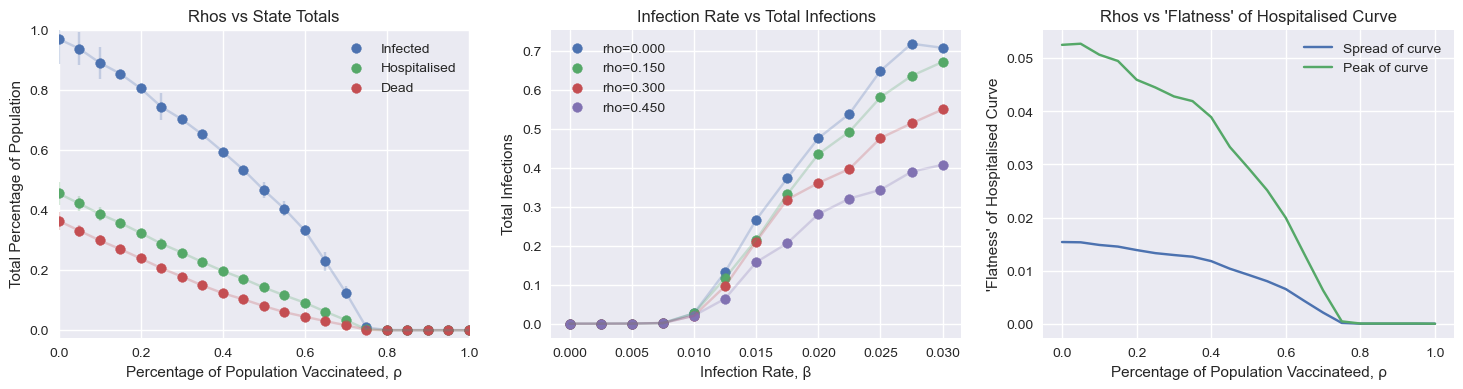

In [36]:
plot_results('section_3a', 'OldestOneOff')

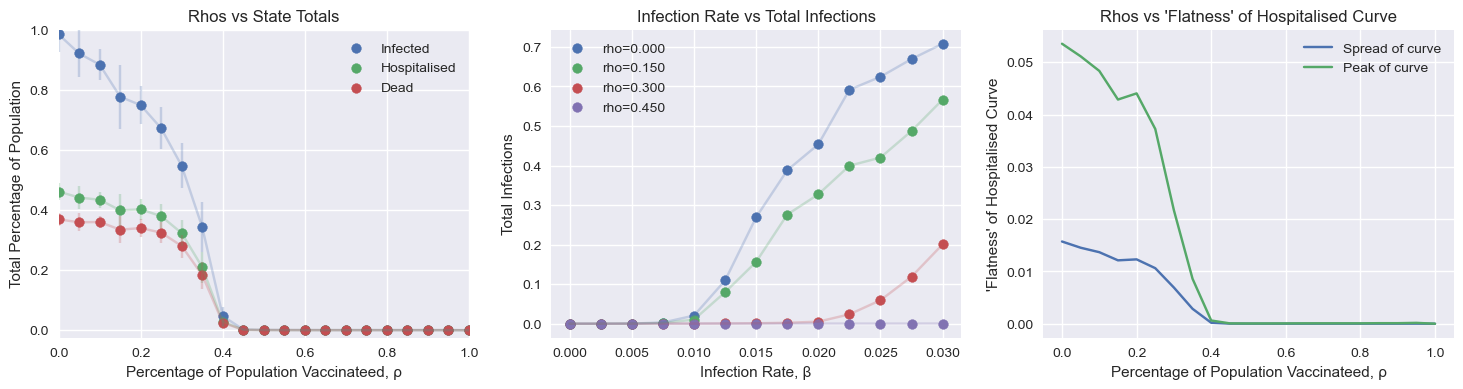

In [37]:
plot_results('section_3b', 'YoungestOneOff')

# Section 4 - Age-Correlated Sliding Intitial Vacciantion

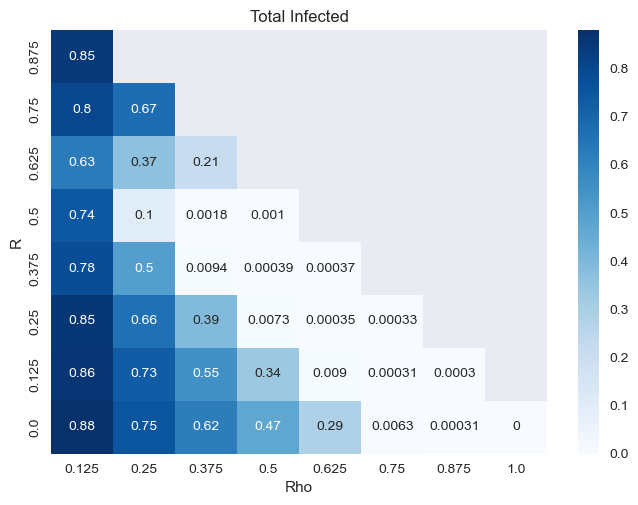

In [12]:
plot_heatmap(run_folder='heatmap', state='Infected')

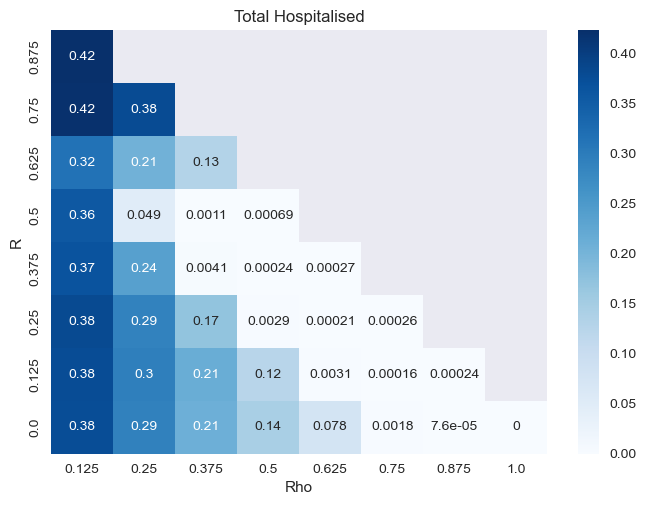

In [13]:
plot_heatmap(run_folder='heatmap', state='Hospitalised')

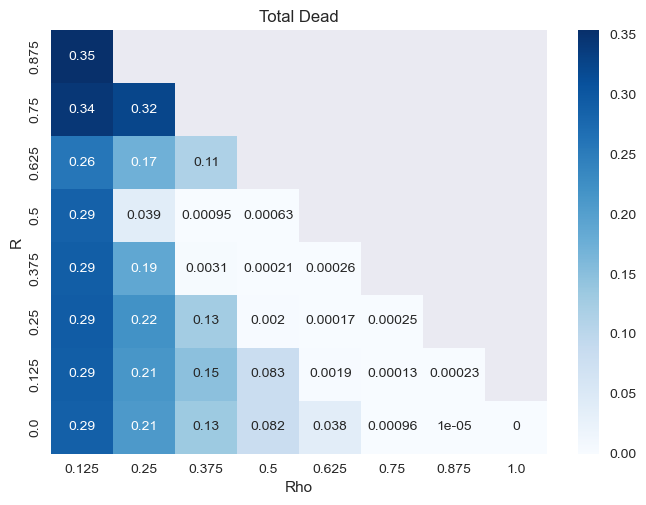

In [14]:
plot_heatmap(run_folder='heatmap', state='Dead')